5) Using sklearn, considering a 10-fold stratified cross validation (random=0), plot the cumulative testing confusion matrices of kNN (uniform weights, k = 5, Euclidean distance) and Naive Bayes (Gaussian assumption). Use all remaining classifier parameters as default.

Loads and reads the parkinson's disease data

In [5]:
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff
import seaborn as sns
import matplotlib.pyplot as plt

data = loadarff('pd_speech.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')

X = df.drop('class', axis=1)
Y = df['class']

Creates the 10-fold cross validator, the KNN and the Gaussian Naive Bayes. Caluculates the confusion matrix of kNN and Naive Bayes:

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0) 

knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')
nb = GaussianNB()

#function to calculate confusion matrix and accuracy so we dont repeat code
def calculate(x, X, Y):
    accuracy = []
    conf_mat = np.zeros((2, 2)) #inicializates the confusion matrix at 0's
    for train, test in skf.split(X, Y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        Y_train, Y_test = Y.iloc[train], Y.iloc[test]

        #normalize data
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        x.fit(X_train, Y_train)

        Y_pred = x.predict(X_test)

        accuracy.append(metrics.accuracy_score(Y_test, Y_pred))
        conf_mat += np.array(confusion_matrix(Y_test, Y_pred, labels=['0', '1']))
    return conf_mat, accuracy

nb_confusion = pd.DataFrame(calculate(nb, X, Y)[0], index=['0', '1'], columns=['Predicted 0', 'Predicted 1'])
knn_confusion = pd.DataFrame(calculate(knn, X, Y)[0], index=['0', '1'], columns=['Predicted 0', 'Predicted 1'])



Plot the confusion matrices of kNN and Bayes Naive

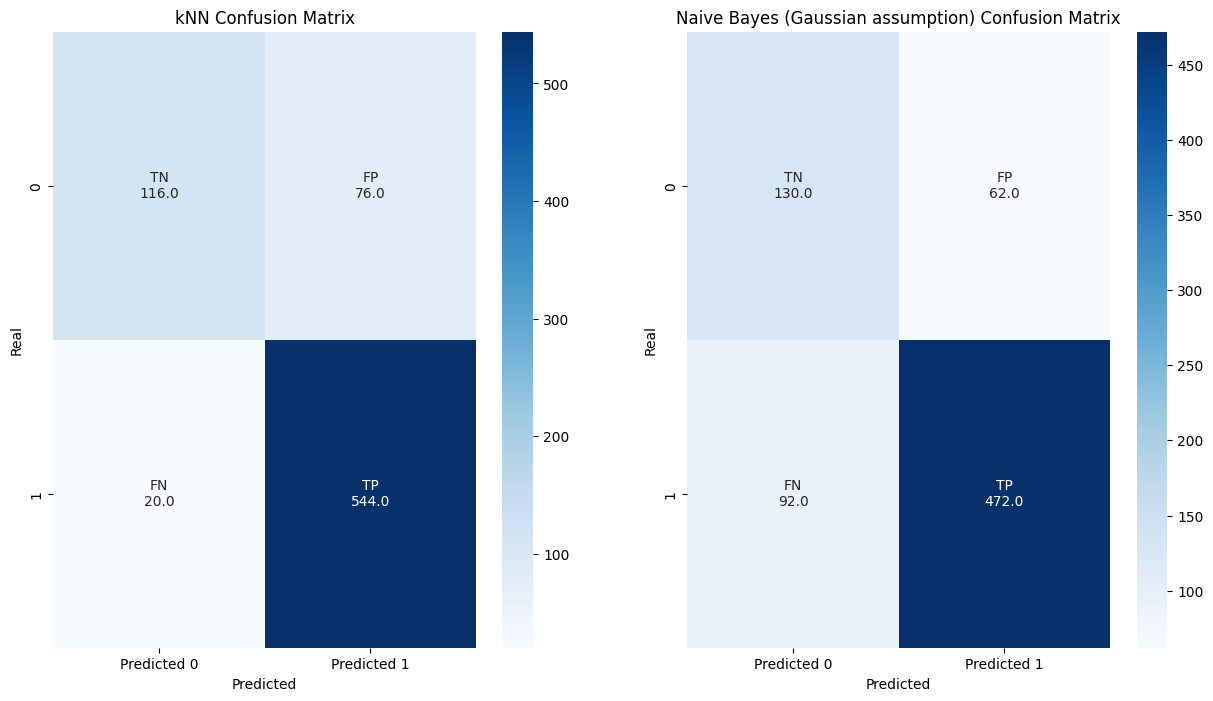

In [7]:
titles = ["kNN Confusion Matrix", "Naive Bayes (Gaussian assumption) Confusion Matrix"]
matrices = [knn_confusion, nb_confusion]
plt.figure(figsize= (15, 8))
for i in range(len(matrices)):
    plt.subplot(1, 2, i+1)
    plt.title(titles[i])
    labels = np.array([["TN\n" + str(matrices[i].iat[0, 0]), "FP\n" + str(matrices[i].iat[0, 1])], ["FN\n" + str(matrices[i].iat[1, 0]), "TP\n" + str(matrices[i].iat[1, 1])]])
    sns.heatmap(matrices[i], annot=labels, fmt='', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Real")


6) Using scipy, test the hypothesis “𝑘NN is statistically superior to Naïve Bayes regarding accuracy”, asserting whether is true.

In [8]:
#H0: kNN is statistically superior to Naive Bayes regarding accuracy

from scipy import stats

res = stats.ttest_rel(calculate(knn, X, Y)[1], calculate(nb, X, Y)[1], alternative='greater')
print("knn < nb? pval=", res.pvalue)


knn < nb? pval= 0.001316817828490826


Resposta:
A função ttest_rel, de scipy.stats, permite-nos testar hipóteses dadas duas amostras relacionadas. Nesta situação, os resultados de kNN e Naive Bayes estão relacionados uma vez que estes classificadores estão a trabalhar no mesmo dataset. 
Utilizámos o parâmetro alternative = 'greater' uma vez que queremos testar se a aaccuracy de kNN é superior à accuracy de Naive Bayes e não o inverso, pelo que um teste à direita é mais adqueado. Assim, temos as hipóteses:
H0: a accuracy de knn é estatisticamente igual à de Naive Bayes
H1: a accuracy de knn é estatisticamente superior à de Naive Bayes

Depois de executarmos o teste chegamos a um p-value de 0.0013168 o que nos leva a concluir que, para um threshold de /alpha = 0.05, devemos rejeitar H0 e portanto aceitar H1. Desta forma concluímos que a accuracy de kNN é estatisticamente superior à accuracy de Naive Bayes.

Aqui em cima em falta a cena de tomar a decisão que depois fazemos

7) Enumerate three possible reasons that could underlie the observed differences in predictive 
accuracy between 𝑘NN and Naïve Bayes.

Resposta:
1. O kNN é um classificador baseado em instâncias, ou seja, o classificador guarda todas as instâncias de treino e usa-as para classificar novas instâncias. Por outro lado, o Naive Bayes é um classificador baseado em modelos, ou seja, o classificador aprende um modelo probabilístico dos dados de treino e usa esse modelo para classificar novas instâncias. Assim, o kNN é mais suscetível a overfitting do que o Naive Bayes, o que pode explicar a diferença de accuracy entre os dois classificadores.

2. O kNN usa a distância euclidiana para calcular a similaridade entre instâncias, enquanto que o Naive Bayes usa a distribuição gaussiana para calcular a probabilidade de uma instância pertencer a uma classe. Assim, o kNN é mais suscetível a outliers do que o Naive Bayes, o que pode explicar a diferença de accuracy entre os dois classificadores.

nova resposta
Pôr como nota que só demos duas razões de acordo com as FAQs.

O modelo de Naive Bayes assume que as features do dataset são mutualmente independentes. Contudo, no dataset com que trabalhamos (um dataset relativamente pequeno e com várias features) tal não acontece o que leva a uma perda de informação e portanto a uma accuracy mais baixa.

A Gaussian assumption de Naive Bayes assume que as variáveis seguem um distribuição normal. Desta forma, ao assumirmos que todas as feautures do dataset com que trabalhamos seguem uma distribuição normal pode levar a um underfit uma vez que não temos as distribuições das features em consideração. Assim, podemos estar a obter resultados diferentes do esperados por uma Gaussian Assumption o que pode levar a uma accuracy mais baixa.